## Energy prediction notebook

In this notebook I will predict the energy usage in different kind of households based on various features. 

In [1283]:
import os
import numpy as np
import pandas as pd ## 2.1.0
import seaborn as sns ## 0.12.2
import matplotlib.pyplot as plt
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)


pandas version: 2.1.0
seaborn version: 0.12.2


#  Data provisioning

The first thing I noticed in my data is that the columns are not seperated and are all combined in 1 large string. 

In [1284]:
file_path = os.path.join(os.path.expanduser("~"), "Downloads", "energyusagedataset.csv")
energyusagedataset = pd.read_csv(file_path)
energyusagedataset.head(10)

,"ID;""Woningtype"";""Gebruiksoppervlakte"";""Bouwjaar"";""Bewonersklasse"";""Hoofdverwarmingsinstallatie"";""Perioden"";""AandeelWoningenMetStadsverwarming_1"";""AandeelWoningenZonnestroomOpAdres_2"";""GemiddeldeAardgasleveringTempGecorr_3"";""GemiddeldeAardgasTempGecPerOpp_13"";""GemiddeldeElektriciteitslevering_23"";""GemElektriciteitsleveringPerBewoner_33"""
0,"0;""T001100"";""T001116"";""T001018"";""T001351"";""T00..."
1,"1;""T001100"";""T001116"";""T001018"";""T001351"";""T00..."
2,"2;""T001100"";""T001116"";""T001018"";""T001351"";""T00..."
3,"3;""T001100"";""T001116"";""T001018"";""T001351"";""A05..."
4,"4;""T001100"";""T001116"";""T001018"";""T001351"";""A05..."
5,"5;""T001100"";""T001116"";""T001018"";""T001351"";""A05..."
6,"6;""T001100"";""T001116"";""T001018"";""A043071"";""T00..."
7,"7;""T001100"";""T001116"";""T001018"";""A043071"";""T00..."
8,"8;""T001100"";""T001116"";""T001018"";""A043071"";""T00..."
9,"9;""T001100"";""T001116"";""T001018"";""A043071"";""A05..."


In [1285]:

with open(file_path, 'r', encoding='utf-8') as file:
    first_line = file.readline()

columns = first_line.strip().split(';')
columns = [col.replace('\ufeff', '').strip('"') for col in columns]  

EnergyData = pd.read_csv(file_path, sep=';', skiprows=1, names=columns, encoding='utf-8')

columns_to_drop = ['Hoofdverwarmingsinstallatie', 'AandeelWoningenMetStadsverwarming_1', 'AandeelWoningenZonnestroomOpAdres_2',]  
EnergyData.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print("Column names:")
print(list(EnergyData.columns))


print("\nSample 10 rows:")
print(EnergyData.head(10).to_string(index=False))






Column names:
['ID', 'Woningtype', 'Gebruiksoppervlakte', 'Bouwjaar', 'Bewonersklasse', 'Perioden', 'GemiddeldeAardgasleveringTempGecorr_3', 'GemiddeldeAardgasTempGecPerOpp_13', 'GemiddeldeElektriciteitslevering_23', 'GemElektriciteitsleveringPerBewoner_33']

Sample 10 rows:
 ID Woningtype Gebruiksoppervlakte Bouwjaar Bewonersklasse Perioden GemiddeldeAardgasleveringTempGecorr_3 GemiddeldeAardgasTempGecPerOpp_13 GemiddeldeElektriciteitslevering_23 GemElektriciteitsleveringPerBewoner_33
  0    T001100             T001116  T001018        T001351 2019JJ00                                  1240                              11.4                                2760                                   1410
  1    T001100             T001116  T001018        T001351 2020JJ00                                  1220                              11.4                                2770                                   1420
  2    T001100             T001116  T001018        T001351 2021JJ00            

### Data understanding
I notice that Woningtype gebruiksoppervlakte, bouwjaar, bewonersklasse,perioden dont have the correct values but have random codes that represent a name so I need to replace them with the correct values. In the preview tabel in the dataset it notes 7 different kind of Woningtypes(Totaal woningen,vrijstaande woningen,2-onder-1kap,Hoekwoning,Tussenwoning,Appartement,Onbekend).In the printed values we also see 7 different kind of types but then with different names. After looking at previews of the table when selecting the woningtypes 1 by 1 I can match the values to the names. this is the result T001100 is Totaal woningen / zw10320 = vrijstaande woning / zw10300 is 2-onder-1-kapwoning / zw25806 is hoekwoning / zw25805 is tussenwoning / zw25810 is appartement / zw25809 is onbekend. This repeats for the other categories asswell.

In [1286]:


EnergyData['GemiddeldeElektriciteitslevering_23'] = pd.to_numeric(EnergyData['GemiddeldeElektriciteitslevering_23'], errors='coerce')


missing_values_count = EnergyData['GemiddeldeElektriciteitslevering_23'].isnull().sum()

print("Number of missing values:", missing_values_count)
EnergyData.dropna(subset=['GemiddeldeElektriciteitslevering_23'], inplace=True)

EnergyData.reset_index(drop=True, inplace=True)

Number of missing values: 11006


In [1287]:
columns_to_analyze = EnergyData[['Woningtype']]

unique_value_counts = columns_to_analyze.apply(lambda col: col.value_counts())

print("Data Types of Selected Columns:")
print(EnergyData.dtypes)

print(unique_value_counts)
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('T001100', 'Totaal woningen')
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('ZW10320', 'vrijstaande woningen')
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('ZW10300', '2-onder-1-kapwoning')
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('ZW25806', 'hoekwoning')
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('ZW25805', 'tussenwoning')
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('ZW25810', 'appartement')
EnergyData['Woningtype'] = EnergyData['Woningtype'].replace('ZW25809', 'onbekend')
column_to_check = EnergyData['Woningtype']
checkvalue = column_to_check.value_counts()
print(checkvalue)

Data Types of Selected Columns:
ID                                          int64
Woningtype                                 object
Gebruiksoppervlakte                        object
Bouwjaar                                   object
Bewonersklasse                             object
Perioden                                   object
GemiddeldeAardgasleveringTempGecorr_3      object
GemiddeldeAardgasTempGecPerOpp_13          object
GemiddeldeElektriciteitslevering_23       float64
GemElektriciteitsleveringPerBewoner_33     object
dtype: object
            Woningtype
Woningtype            
T001100           2384
ZW25810           2341
ZW25805           2193
ZW10320           2168
ZW25806           2067
ZW10300           2033
Woningtype
Totaal woningen         2384
appartement             2341
tussenwoning            2193
vrijstaande woningen    2168
hoekwoning              2067
2-onder-1-kapwoning     2033
Name: count, dtype: int64


In [1288]:
columns_to_analyze = EnergyData[['Gebruiksoppervlakte']]

unique_value_counts = columns_to_analyze.apply(lambda col: col.value_counts())

print(unique_value_counts)
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('T001116', 'Totaal')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A050300', '2 tot 50 m² ')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A025408', '50 tot 75 m²')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A025409', '75 tot 100 m²')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A025410', '100 tot 150 m²')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A025411', '150 tot 250 m²')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A050301', '250 tot 10000 m²')
EnergyData['Gebruiksoppervlakte'] = EnergyData['Gebruiksoppervlakte'].replace('A025414', 'onbekend')
column_to_check = EnergyData['Gebruiksoppervlakte']
checkvalue = column_to_check.value_counts()
print(checkvalue)

                     Gebruiksoppervlakte
Gebruiksoppervlakte                     
T001116                             2016
A025410                             2016
A025411                             2016
A025409                             1985
A050301                             1891
A025408                             1788
A050300                             1390
A025414                               84
Gebruiksoppervlakte
Totaal              2016
100 tot 150 m²      2016
150 tot 250 m²      2016
75 tot 100 m²       1985
250 tot 10000 m²    1891
50 tot 75 m²        1788
2 tot 50 m²         1390
onbekend              84
Name: count, dtype: int64


In [1289]:
columns_to_analyze = EnergyData[['Bouwjaar']]

unique_value_counts = columns_to_analyze.apply(lambda col: col.value_counts())

print(unique_value_counts)
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('T001018', 'Totaal')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25799', '1000 / 1946')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25800', '1946 / 1965')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW10406', '1965 / 1975')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25801', '1975 / 1992')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25815', '1992 / 2006')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25818', '2006 / 2015')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25797', '2015 / heden')
EnergyData['Bouwjaar'] = EnergyData['Bouwjaar'].replace('ZW25798', 'bouwjaar onbekend')
column_to_check = EnergyData['Bouwjaar']
checkvalue = column_to_check.value_counts()
print(checkvalue)

          Bouwjaar
Bouwjaar          
T001018       1786
ZW25799       1763
ZW25800       1718
ZW25801       1679
ZW10406       1674
ZW25815       1620
ZW25818       1540
ZW25797       1406
Bouwjaar
Totaal          1786
1000 / 1946     1763
1946 / 1965     1718
1975 / 1992     1679
1965 / 1975     1674
1992 / 2006     1620
2006 / 2015     1540
2015 / heden    1406
Name: count, dtype: int64


In [1290]:
columns_to_analyze = EnergyData[['Bewonersklasse']]

unique_value_counts = columns_to_analyze.apply(lambda col: col.value_counts())

print(unique_value_counts)
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('T001351', 'Totaal')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043071', '0')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043072', '1')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043073', '2')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043074', '3')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043075', '4')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043076', '5 of meer')
EnergyData['Bewonersklasse'] = EnergyData['Bewonersklasse'].replace('A043077', 'onbekend')
column_to_check = EnergyData['Bewonersklasse']
checkvalue = column_to_check.value_counts()
print(checkvalue)

                Bewonersklasse
Bewonersklasse                
T001351                   2032
A043072                   1967
A043073                   1952
A043071                   1865
A043074                   1849
A043075                   1819
A043076                   1702
Bewonersklasse
Totaal       2032
1            1967
2            1952
0            1865
3            1849
4            1819
5 of meer    1702
Name: count, dtype: int64


In [1291]:
columns_to_analyze = EnergyData[['Perioden']]

unique_value_counts = columns_to_analyze.apply(lambda col: col.value_counts())

print(unique_value_counts)
EnergyData['Perioden'] = EnergyData['Perioden'].replace('2019JJ00', '2019')
EnergyData['Perioden'] = EnergyData['Perioden'].replace('2020JJ00', '2020')
EnergyData['Perioden'] = EnergyData['Perioden'].replace('2021JJ00', '2021')
column_to_check = EnergyData['Perioden']
checkvalue = column_to_check.value_counts()
print(checkvalue)

          Perioden
Perioden          
2019JJ00      4464
2020JJ00      4372
2021JJ00      4350
Perioden
2019    4464
2020    4372
2021    4350
Name: count, dtype: int64


In [1292]:
EnergyData.head(10)

,ID,Woningtype,Gebruiksoppervlakte,Bouwjaar,Bewonersklasse,Perioden,GemiddeldeAardgasleveringTempGecorr_3,GemiddeldeAardgasTempGecPerOpp_13,GemiddeldeElektriciteitslevering_23,GemElektriciteitsleveringPerBewoner_33
0,0,Totaal woningen,Totaal,Totaal,Totaal,2019,1240,11.4,2760.0,1410
1,1,Totaal woningen,Totaal,Totaal,Totaal,2020,1220,11.4,2770.0,1420
2,2,Totaal woningen,Totaal,Totaal,Totaal,2021,1240,11.5,2810.0,1450
3,3,Totaal woningen,Totaal,Totaal,Totaal,2019,1320,12.0,2760.0,1410
4,4,Totaal woningen,Totaal,Totaal,Totaal,2020,1310,12.1,2770.0,1420
5,5,Totaal woningen,Totaal,Totaal,Totaal,2021,1330,12.1,2800.0,1430
6,6,Totaal woningen,Totaal,Totaal,0,2019,1120,12.0,1950.0,NaN
7,7,Totaal woningen,Totaal,Totaal,0,2020,1120,13.3,2040.0,NaN
8,8,Totaal woningen,Totaal,Totaal,0,2021,1110,13.0,2020.0,NaN
9,9,Totaal woningen,Totaal,Totaal,0,2019,1190,12.2,1940.0,NaN


In the preview tabel in the dataset it notes 7 different kind of Woningtypes(Totaal woningen,vrijstaande woningen,2-onder-1kap,Hoekwoning,Tussenwoning,Appartement,Onbekend).In the printed values we also see 7 different kind of types but then with different names. After looking at previews of the table when selecting the woningtypes 1 by 1 i can match the values to the names. this is the result T001100 is Totaal woningen / zw10320 = vrijstaande woning / zw10300 is 2-onder-1-kapwoning / zw25806 is hoekwoning / zw25805 is tussenwoning / zw25810 is appartement / zw25809 is onbekend



c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


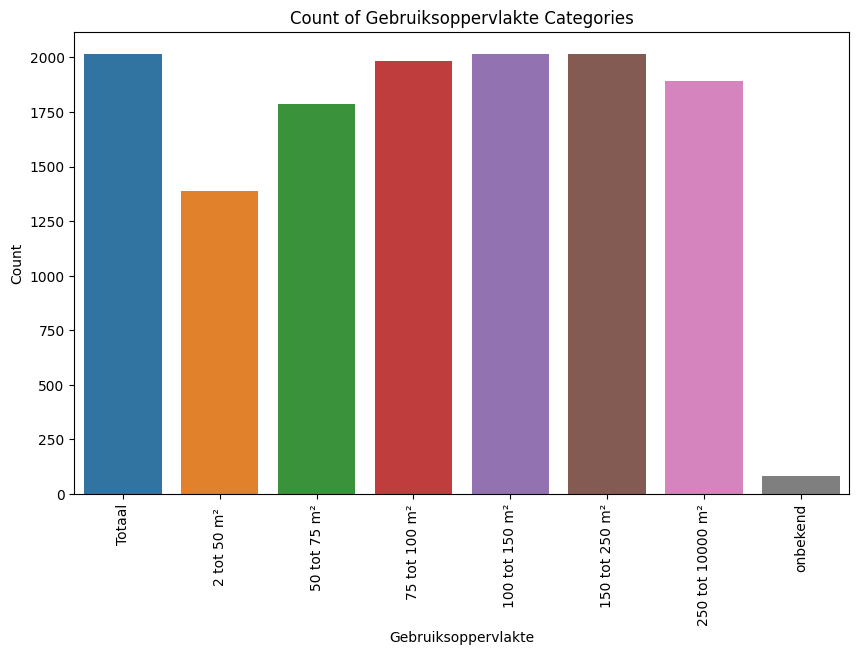

In [1293]:

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='Gebruiksoppervlakte', data=EnergyData)
plt.xticks(rotation=90)  
plt.xlabel('Gebruiksoppervlakte')
plt.ylabel('Count')
plt.title('Count of Gebruiksoppervlakte Categories')
plt.show()

We can see that the data is preprocessed because the count is equal for every feature except the values that we want to predict. after dropping rows with missing values for the electricity usage you can tell they were mostly onbekend but also 2-50m²

## Feature selection
because we have some catergorical values that can't be converted to numerical i will be giving them an id like 0,1,2,3 to create a heatplot

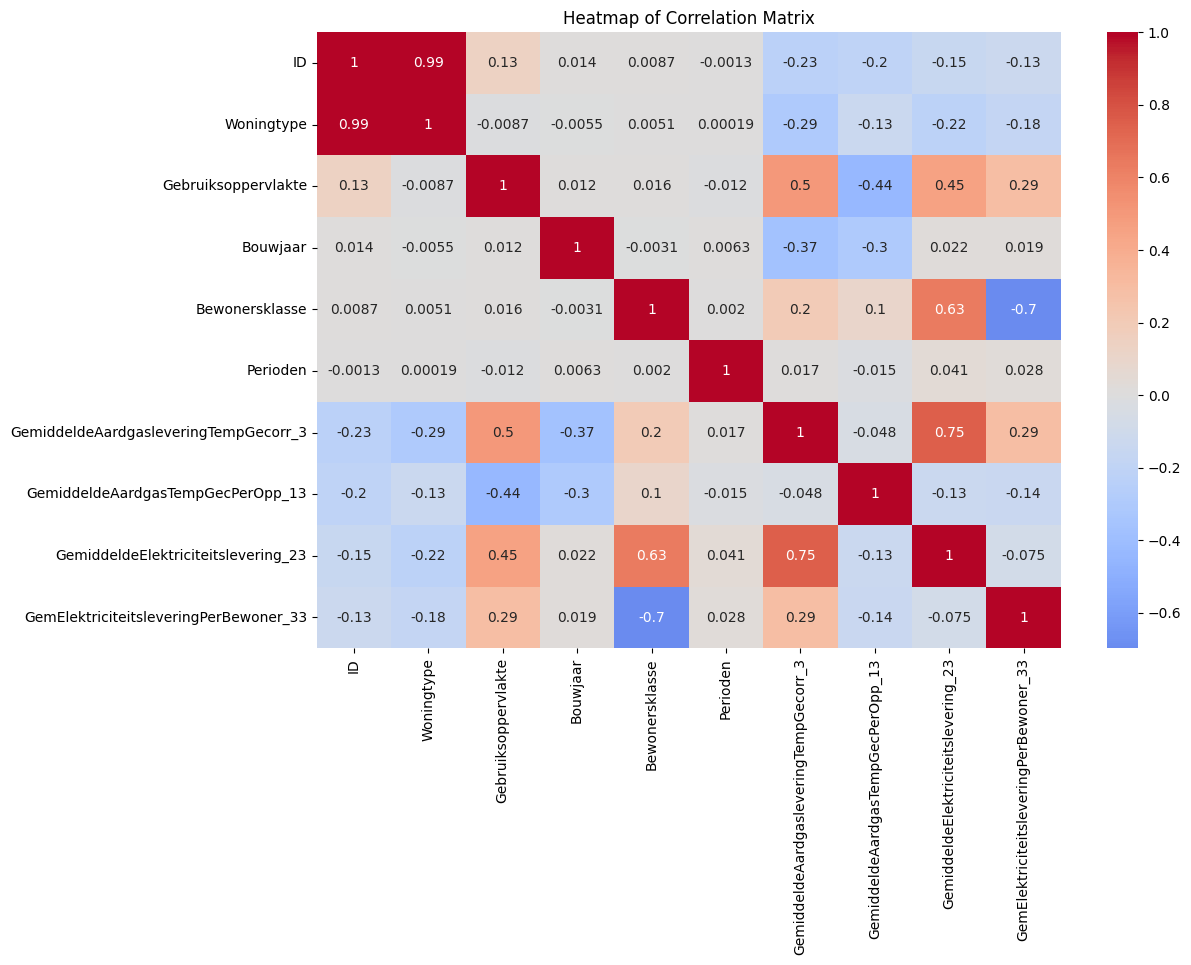

In [1294]:

EnergyData_copy2 = EnergyData.copy()
columns_to_convert = ['Bewonersklasse', 'Perioden', 
                      'GemiddeldeAardgasleveringTempGecorr_3', 'GemiddeldeAardgasTempGecPerOpp_13', 
                      'GemiddeldeElektriciteitslevering_23', 'GemElektriciteitsleveringPerBewoner_33']

for col in columns_to_convert:
    EnergyData_copy2[col] = pd.to_numeric(EnergyData_copy2[col], errors='coerce')

EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('Totaal woningen', '0')
EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('vrijstaande woningen', '1')
EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('2-onder-1-kapwoning', '2')
EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('hoekwoning', '3')
EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('tussenwoning', '4')
EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('appartement', '5')
EnergyData_copy2['Woningtype'] = EnergyData_copy2['Woningtype'].replace('onbekend', '6')  
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('Totaal', '0')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('1000 / 1946', '1')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('1946 / 1965', '2')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('1965 / 1975', '3')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('1975 / 1992', '4')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('1992 / 2006', '5')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('2006 / 2015', '6')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('2015 / heden', '7')
EnergyData_copy2['Bouwjaar'] = EnergyData_copy2['Bouwjaar'].replace('bouwjaar onbekend', '8')  
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('Totaal', '0')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('2 tot 50 m² ', '1')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('50 tot 75 m²', '2')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('75 tot 100 m²', '3')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('100 tot 150 m²', '4')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('150 tot 250 m²', '5')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('250 tot 10000 m²', '6')
EnergyData_copy2['Gebruiksoppervlakte'] = EnergyData_copy2['Gebruiksoppervlakte'].replace('onbekend', '7')

plt.figure(figsize=(12, 8))
sns.heatmap(EnergyData_copy2.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlation Matrix')
plt.show()





since I am focussing on the GemiddeldeElektriciteitslevering I can see that Bewonersklasse / gemiddeldeaardgasleveringtempgecorr / gebruiksoppervlakte would be good features to use.

In [1295]:
EnergyData_copy2.dropna(subset=['Bewonersklasse'], inplace=True)

EnergyData_copy2.reset_index(drop=True, inplace=True)
features = ["Bewonersklasse", "GemiddeldeAardgasleveringTempGecorr_3","Gebruiksoppervlakte","Woningtype","Bouwjaar"]
target = "GemiddeldeElektriciteitslevering_23"
X = EnergyData_copy2[features]
y = EnergyData_copy2[target]

In [1296]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dolma\AppData\Local\Temp\ipykernel_3024\135505423.py:7: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in M

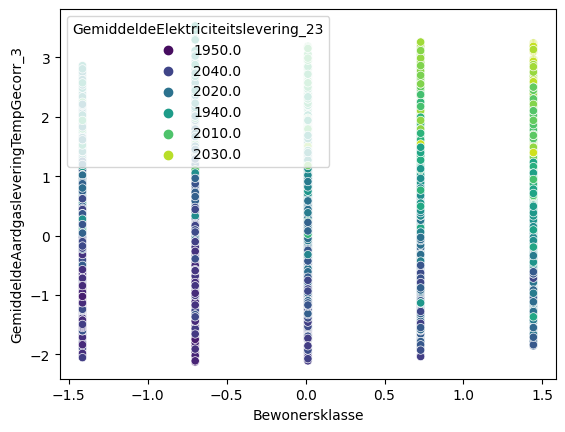

In [1297]:


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
plot = sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, palette="viridis")
plot.set(xlabel=X.columns[0], ylabel=X.columns[1], title="")
plot.legend(plot.legend_.legendHandles, EnergyData_copy2["GemiddeldeElektriciteitslevering_23"].unique(), title="GemiddeldeElektriciteitslevering_23")

In [1298]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

model = KNeighborsClassifier(n_neighbors=1) 
model.fit(X_train, y_train)
pred = model.predict(X_test)


score = accuracy_score(pred, y_test)
print("Accuracy:", score)

tolerance = 20  
within_tolerance = abs(y_test - pred) <= tolerance
accuracy_within_tolerance = within_tolerance.mean()
print("Accuracy within tolerance:", accuracy_within_tolerance)

unique_class_labels = np.unique(y_test)
class_names = [str(label) for label in unique_class_labels]

report = classification_report(y_test, pred, labels=unique_class_labels, target_names=class_names)
print("Classification Report:")
print(report)


Accuracy: 0.08302485457429931
Accuracy within tolerance: 0.37546271813855103
Classification Report:
              precision    recall  f1-score   support

       960.0       0.00      0.00      0.00         1
      1030.0       0.00      0.00      0.00         1
      1040.0       0.00      0.00      0.00         1
      1080.0       0.00      0.00      0.00         1
      1110.0       0.00      0.00      0.00         1
      1200.0       0.00      0.00      0.00         1
      1210.0       0.00      0.00      0.00         1
      1220.0       0.00      0.00      0.00         1
      1230.0       0.00      0.00      0.00         1
      1240.0       0.00      0.00      0.00         1
      1250.0       0.00      0.00      0.00         1
      1260.0       0.33      1.00      0.50         1
      1270.0       0.00      0.00      0.00         2
      1280.0       0.33      0.50      0.40         2
      1290.0       0.00      0.00      0.00         4
      1310.0       0.00      0.00  

c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dolma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

after testing k numbers 1 stands out as the best. The accuracy is incredibly low with the 3 features i initially chosen it is around 0.05 and when i add 2 other features with less relevance it comes up around 0.085

## conclusion
With only these features the model has a really hard time guessing the value this could also come because I decided to drop rows with missing values. I also conclude when i say theprediction can be off by 20 the accuracy increases by 4 times.